In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")

In [ ]:
raw_datasets

In [ ]:
raw_datasets["train"]

In [ ]:
#everything is saved to disk using apache arrow, which means if your dataset is huge, you won't get out of ram

In [ ]:
raw_datasets["train"][:5]

{'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
  'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .'],
 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
  "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .",
  "On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",
  'Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at 

In [ ]:
raw_datasets["train"].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [ ]:
from transformers import AutoTokenizer

checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example):
  return tokenizer(example["sentence1"], example["sentence2"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = raw_datasets.map(tokenize_function)
print(tokenized_datasets.column_names)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'train': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'validation': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
#tokenizer backed by rust, multiprocessing by map method,

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.with_format("torch")

print(tokenized_datasets["train"])
tokenized_datasets

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3668
})


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [ ]:
small_dataset = tokenized_datasets["train"].select(range(300))

In [ ]:
small_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 300
})

# Processing Sentence Pairs

In [ ]:
 #token type ids tell which sentence belongs to the first sentence and which belongs to the second sentence

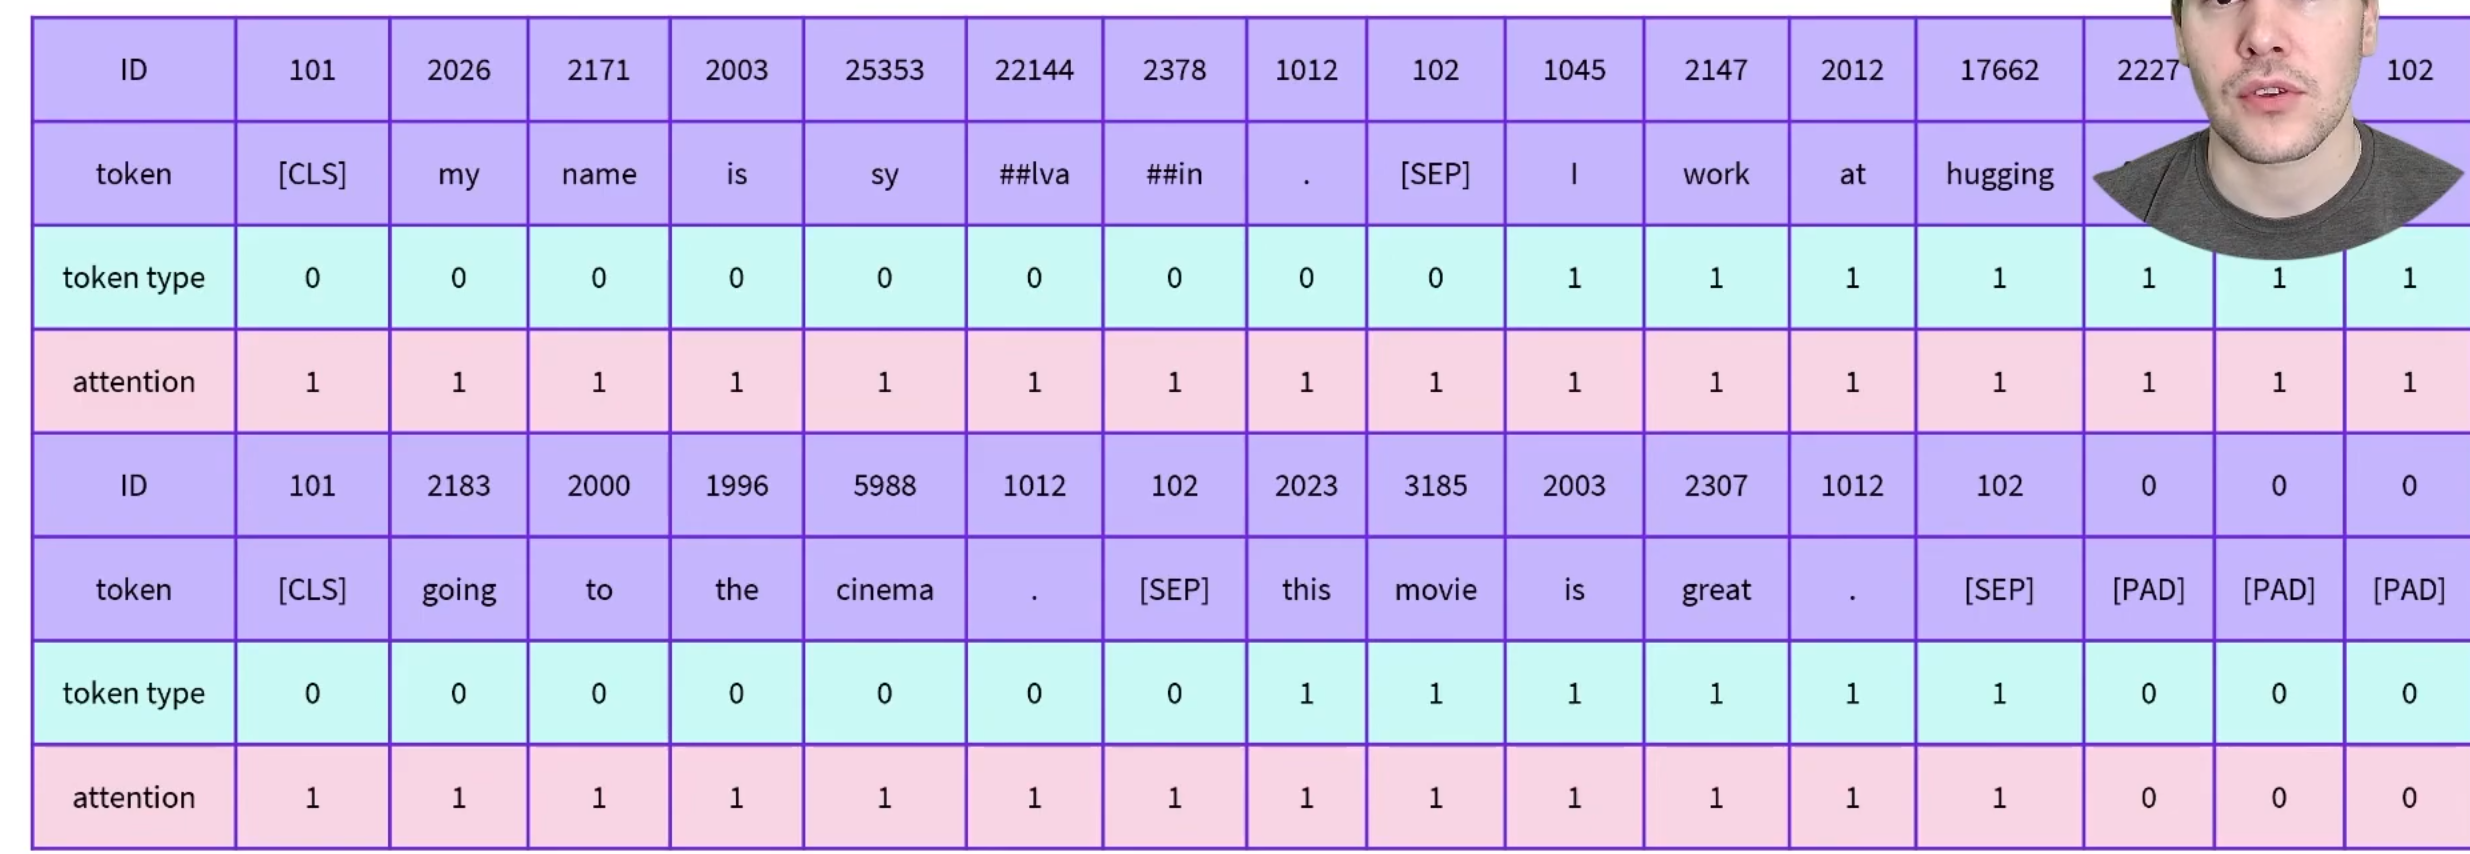

In [ ]:
"""PAdding to same lngth
pro: all batches have same shape
cons: lots of batches wull have useless columns with pad token only, more computations


another strategy is to pad the elements when we batch them together, will speed up CPU & GPU usage
"""

'PAdding to same lngth\npro: all batches have same shape\ncons: lots of batches wull have useless columns with pad token only, more computations'

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
"""to apply dynmaic paddding, we must defer the padding to the batch preparation, so we remove that part from our tokenize function, we will still leave the
    truncation part so that the inputds are biger than the maicmum lenggth accepted by hte model (usually 512) get truncated to that length, then we pad out
    dynamically by ysing a data collator
  we still leave the truncation part, those classes inthe transformers library are all applying the final procerssing needed before forminh a batch,
  datacollatorwithpadding will pad the samples to thte macimum inside of sentences, we pass it to  the pytirch dataloader as the collate function, then observe the bacthes generated have various lengths
  all way below from 128, dynamic batching faster on CPU/GPUS, remember to change it back to TPU
  to

"""

'to apply dynmaic paddding, we must defer the padding to the batch preparation, so we remove that part from our tokenize function'

In [ ]:
from transformers import AutoTokenizer

checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_function(example):
  return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function)
print(tokenized_datasets.column_names)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'train': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'validation': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print(tokenized_datasets.column_names)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'train': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'validation': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.with_format("torch")

print(tokenized_datasets["train"])
tokenized_datasets

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3668
})


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=data_collator)

for step, batch in enumerate(train_dataloader):
  print(batch["input_ids"].shape)
  if step > 5:
    break

torch.Size([16, 76])
torch.Size([16, 73])
torch.Size([16, 73])
torch.Size([16, 71])
torch.Size([16, 82])
torch.Size([16, 73])
torch.Size([16, 74])


# The Trainer API

In [ ]:
!pip install transformers==4.30
!pip install accelerate -U

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


In [ ]:
# from datasets import load_da
raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_function(example):
  return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function)
print(tokenized_datasets.column_names)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'train': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'validation': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print(tokenized_datasets.column_names)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'train': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'validation': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']}


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)
# train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=data_collator)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
                "test-trainer",
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                num_train_epochs=5,
                learning_rate=2e-5,
                weight_decay=0.01,
                )

In [ ]:
from transformers import Trainer

trainer = Trainer(
          model,
          training_args,
          train_dataset=tokenized_datasets["train"].select(range(50)),
          eval_dataset=tokenized_datasets["validation"].select(range(50)),
          data_collator=data_collator,
          tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=20, training_loss=0.586736011505127, metrics={'train_runtime': 217.7175, 'train_samples_per_second': 1.148, 'train_steps_per_second': 0.092, 'total_flos': 9526470203640.0, 'train_loss': 0.586736011505127, 'epoch': 5.0})

In [ ]:
#this just gives us a training loss, which doesn't specify how good are model is performing

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])

In [ ]:
print(predictions.predictions.shape, predictions.label_ids.shape)

(408, 2) (408,)


In [ ]:
import numpy as np
from datasets import load_metric

In [ ]:
metric = load_metric("glue", "mrpc")
preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

<ipython-input-20-238213529d42>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'accuracy': 0.696078431372549, 'f1': 0.8098159509202455}

In [ ]:
"for training we need to write a function which does the same step as done above"

In [ ]:
metric = load_metric("glue", "mrpc")
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
training_args= TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"].select(range(50)),
    eval_dataset=tokenized_datasets["validation"].select(range(50)),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.670051,0.600000,0.750000
2,No log,0.646695,0.640000,0.769231
3,No log,0.640650,0.680000,0.771429


TrainOutput(global_step=21, training_loss=0.621973991394043, metrics={'train_runtime': 225.545, 'train_samples_per_second': 0.665, 'train_steps_per_second': 0.093, 'total_flos': 5407137743160.0, 'train_loss': 0.621973991394043, 'epoch': 3.0})